# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch.optim as optim
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
import time
print(device)

cuda


In [2]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [3]:
train_data = load_data('train_data.pkl')

In [4]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [5]:
# function for plotting some examples:
def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)
    
    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 432x288 with 0 Axes>

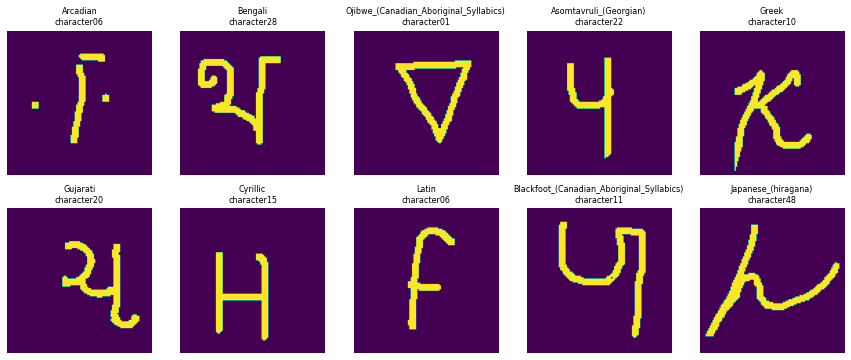

In [6]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [7]:
alphabet_lengths = {}
for i in range(len(list(train_data.keys()))):
    alphabet = alphabets[i]  # a dict
    characters_for_this_alphabet = list(train_data[alphabet].keys())
    alphabet_lengths[alphabet] = len(characters_for_this_alphabet)
alphabet_lengths

{'Alphabet_of_the_Magi': 20,
 'Anglo-Saxon_Futhorc': 29,
 'Arcadian': 26,
 'Armenian': 41,
 'Asomtavruli_(Georgian)': 40,
 'Balinese': 24,
 'Bengali': 46,
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': 14,
 'Braille': 26,
 'Burmese_(Myanmar)': 34,
 'Cyrillic': 33,
 'Early_Aramaic': 22,
 'Futurama': 26,
 'Grantha': 43,
 'Greek': 24,
 'Gujarati': 48,
 'Hebrew': 22,
 'Inuktitut_(Canadian_Aboriginal_Syllabics)': 16,
 'Japanese_(hiragana)': 52,
 'Japanese_(katakana)': 47,
 'Korean': 40,
 'Latin': 26,
 'Malay_(Jawi_-_Arabic)': 40,
 'Mkhedruli_(Georgian)': 41,
 'N_Ko': 33,
 'Ojibwe_(Canadian_Aboriginal_Syllabics)': 14,
 'Sanskrit': 42,
 'Syriac_(Estrangelo)': 23,
 'Tagalog': 17,
 'Tifinagh': 55}

In [8]:
train_data.keys()

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])

In [9]:
len(train_data['N_Ko']['character01'])

20

In [10]:
char_dict = {f"character{i:02d}": i - 1 for i in range(1, 100)}

batch_size = 20
train_loader_dict = {}
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets:
    data_alphabet = train_data[alphabet]
    image_label_list = []
    for label, images in data_alphabet.items():
        # Append each image-label pair as a tuple to the list
        for image in images:
            image_label_list.append((image, char_dict[label]))
    train_loader = torch.utils.data.DataLoader(image_label_list, batch_size=batch_size, shuffle=True)
    train_loader_dict[alphabet] = train_loader
train_loader_dict

{'Alphabet_of_the_Magi': <torch.utils.data.dataloader.DataLoader at 0x2b1cead6708>,
 'Anglo-Saxon_Futhorc': <torch.utils.data.dataloader.DataLoader at 0x2b1c02dcd48>,
 'Arcadian': <torch.utils.data.dataloader.DataLoader at 0x2b1ceb2e308>,
 'Armenian': <torch.utils.data.dataloader.DataLoader at 0x2b1ceb65fc8>,
 'Asomtavruli_(Georgian)': <torch.utils.data.dataloader.DataLoader at 0x2b1cebc6b48>,
 'Balinese': <torch.utils.data.dataloader.DataLoader at 0x2b1cec20408>,
 'Bengali': <torch.utils.data.dataloader.DataLoader at 0x2b1cec5f0c8>,
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': <torch.utils.data.dataloader.DataLoader at 0x2b1cedd6648>,
 'Braille': <torch.utils.data.dataloader.DataLoader at 0x2b1cedf9348>,
 'Burmese_(Myanmar)': <torch.utils.data.dataloader.DataLoader at 0x2b1cee32fc8>,
 'Cyrillic': <torch.utils.data.dataloader.DataLoader at 0x2b1cee85608>,
 'Early_Aramaic': <torch.utils.data.dataloader.DataLoader at 0x2b1ceecf308>,
 'Futurama': <torch.utils.data.dataloader.DataLoader a

In [11]:

print(len(train_loader_dict['Latin']))
for batch_idx, (inputs, targets) in enumerate(train_loader_dict['Latin']):
    print(f"Batch {batch_idx}:")
    print("Inputs (features):")
    print(type(inputs))
    print(inputs)  # Print input data (features)
    print("Targets (labels):")
    print(targets)  # Print target data (labels)


26
Batch 0:
Inputs (features):
<class 'torch.Tensor'>
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0

In [12]:


class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 26 * 26, 64)  # Adjusted based on input image size of 105x105

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc(x))
        return x

class BaseCNN2(nn.Module):
    def __init__(self):
        super(BaseCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 13 * 13, 512)  # Adjusted based on input image size of 105x105
        self.fc2 = nn.Linear(512, 64)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))

        return x

class BaseCNN3(nn.Module):
    def __init__(self):
        super(BaseCNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 26 * 26, 128)  # Adjusted based on input image size of 105x105
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))

        return x

class CustomModel(nn.Module):
    def __init__(self, alphabet_num_classes):
        super(CustomModel, self).__init__()
        self.base_cnn = BaseCNN()
        self.alphabet_classifiers = nn.ModuleDict({
            alphabet: nn.Linear(64, num_classes) for alphabet, num_classes in alphabet_num_classes.items()
        })

    def forward(self, x):
        features = self.base_cnn(x)
        outputs = {alphabet: classifier(features) for alphabet, classifier in self.alphabet_classifiers.items()}
        return outputs

In [13]:

# Create an instance of the custom model
model = CustomModel(alphabet_lengths)
model.to(device)
# Define loss functions and optimizer
loss_functions = {alphabet: nn.CrossEntropyLoss() for alphabet in alphabet_lengths}
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs=10
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}')
    train_loss, correct, conf = 0, 0, 0
    total_train_loss, total_correct, total_samples = 0, 0, 0
    start_time= time.time()
    model.train()
    for alphabet in alphabets:
        train_loss, correct, conf = 0, 0, 0
        train_loader = train_loader_dict[alphabet]
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            Y_pred = torch.nn.functional.softmax(outputs[alphabet], dim=1)
            loss = loss_functions[alphabet](outputs[alphabet], targets)
            loss.backward()
            optimizer.step()
            inputs.requires_grad_(False)
            with torch.no_grad():
                train_loss += loss.item()
                confBatch, predicted = Y_pred.max(1)
                correct += predicted.eq(targets).sum().item()
                conf+=confBatch.sum().item()
                total_samples+=batch_size
                total_train_loss+=train_loss
        total_correct+=correct
        execution_time = (time.time() - start_time)
        print(f'Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f -- {alphabet} -- '% (train_loss/len(train_loader), 100.*correct/len(train_loader.dataset), correct, len(train_loader.dataset), 100*conf/len(train_loader.dataset), execution_time))
    print(f'\nTOTAL LOSS: {total_train_loss/total_samples}, TOTAL ACCURACY: {(total_correct/total_samples)*100} %\n')

Epoch: 1
Loss: 2.862 | Acc: 13.000% (52/400) | Conf 9.83 | time (s): 12.95 -- Alphabet_of_the_Magi -- 
Loss: 3.137 | Acc: 11.724% (68/580) | Conf 11.90 | time (s): 13.92 -- Anglo-Saxon_Futhorc -- 
Loss: 3.320 | Acc: 4.615% (24/520) | Conf 6.31 | time (s): 14.79 -- Arcadian -- 
Loss: 3.639 | Acc: 5.732% (47/820) | Conf 4.19 | time (s): 16.27 -- Armenian -- 
Loss: 3.743 | Acc: 4.125% (33/800) | Conf 3.90 | time (s): 17.70 -- Asomtavruli_(Georgian) -- 
Loss: 3.153 | Acc: 6.458% (31/480) | Conf 5.43 | time (s): 18.66 -- Balinese -- 
Loss: 3.800 | Acc: 3.587% (33/920) | Conf 3.86 | time (s): 20.26 -- Bengali -- 
Loss: 2.562 | Acc: 12.857% (36/280) | Conf 10.65 | time (s): 20.80 -- Blackfoot_(Canadian_Aboriginal_Syllabics) -- 
Loss: 3.227 | Acc: 7.692% (40/520) | Conf 6.64 | time (s): 21.76 -- Braille -- 
Loss: 3.532 | Acc: 6.324% (43/680) | Conf 4.65 | time (s): 22.91 -- Burmese_(Myanmar) -- 
Loss: 3.472 | Acc: 4.545% (30/660) | Conf 4.59 | time (s): 24.15 -- Cyrillic -- 
Loss: 3.103 | Acc:

In [47]:
# load the test data:

data_dict_test = load_data('test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())

    


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [48]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Mongolian annotated images: torch.Size([30, 1, 105, 105])
Number of Mongolian annotated labels: 30
Shape of Mongolian unseen images: torch.Size([570, 1, 105, 105])
Number of Mongolian unseen labels: 570. Use the unseen labels only for evaluating your model!


In [ ]:
# evaluation of the model:

In [49]:
alphabets_test

['Angelic',
 'Atemayar_Qelisayer',
 'Atlantean',
 'Aurek-Besh',
 'Avesta',
 'Ge_ez',
 'Glagolitic',
 'Gurmukhi',
 'Kannada',
 'Keble',
 'Malayalam',
 'Manipuri',
 'Mongolian',
 'Old_Church_Slavonic_(Cyrillic)',
 'Oriya',
 'Sylheti',
 'Syriac_(Serto)',
 'Tengwar',
 'Tibetan',
 'ULOG']

# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same. 

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]  
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
